## Infection Path Analysis Using Routes

The purpose of this notebook is to try and analyse the path of infection for COVID-19. Below is a brief description of how the algorithm works.

### Path of Infection Algorithm

1. Pick a sufficiently large threshold (infected_thresh) which indicates when a location has been infected.
2. Using time series data, add the location that first recorded infections (even if it is below the threshold).
3. If a location becomes infected and has a direct path to another location that is infected then add an edge. If it does not have a direct path to another infected location then decrease infected_thresh and go back to step 2.
4. Repeat step 3 for all the time series data. If all infected locations are added and the rule defined in step 3 is never broken and the graph contains x% of the countries that have recorded COVID-19 

In [1]:
%matplotlib notebook
from covid_data import CovidData
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time

In [2]:
from ipyleaflet import (
    Map, basemaps, basemap_to_tiles, Circle, 
    Marker, FullScreenControl, LayersControl, 
    LayerGroup, CircleMarker, Polyline, WidgetControl
)

from ipywidgets import HTML

In [3]:
covid_data_manager = CovidData()

bin_region_column = 'state'
covid_data, routes_data = covid_data_manager.getData(bin_region_column=bin_region_column)
data_confirmed = covid_data['confirmed']
border_closures = covid_data_manager.loadBorderDataset()
data_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20
0,Alabama,US,32.884280,-86.710122,0,0,0,0,0,0,...,11674,11771,12086,12376,13052,13288,13670,14117,14478,14986
1,Alaska,US,60.261375,-145.838598,0,0,0,0,0,0,...,387,387,387,399,401,401,403,407,407,408
2,Alberta,Canada,53.933300,-116.576500,0,0,0,0,0,0,...,6587,6644,6683,6716,6735,6768,6800,6818,6860,6879
3,American Samoa,US,-14.271000,-170.132000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anguilla,United Kingdom,18.220600,-63.068600,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,none,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,376,381,388,391,398,423,423,423,423,423
317,none,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,9,9
318,none,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,122,128,130,167,184,197,209,212,222,233
319,none,Zambia,-15.416700,28.283300,0,0,0,0,0,0,...,679,753,761,772,832,866,920,920,920,920


In [28]:
def clean_data(data_confirmed):
    return data_confirmed.loc[(data_confirmed['Lat'] != 0) & (data_confirmed['Long'] != 0)]

def clean_routes(routes, bin_region_column):
    if bin_region_column == 'county':
        return routes.loc[~((routes['DepartCounty'] == routes['ArrivalCounty']) &
                            (routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    elif bin_region_column == 'state':
        return routes.loc[~((routes['DepartProvince/State'] == routes['ArrivalProvince/State']) &
                            (routes['DepartCountry/Region'] == routes['ArrivalCountry/Region']))]
    else:
        return routes.loc[~(routes['DepartCountry/Region'] == routes['ArrivalCountry/Region'])]
    
data_confirmed = clean_data(data_confirmed)
routes = clean_routes(routes_data, bin_region_column)

In [57]:
def get_initial_infect_thresh(data_confirmed, infect_percent):
    latest_date = data_confirmed.columns.tolist()[-1]
    num_of_countries = data_confirmed.shape[0]
    return data_confirmed.sort_values(latest_date).iloc[int(num_of_countries*(1-infect_percent))][latest_date]

def route_indexes_between_nodes(node_loc_0, node_loc_1, routes, bin_region_column):
        node_loc_names_0 = node_loc_0.split(':')
        node_loc_names_1 = node_loc_1.split(':')
        
        if bin_region_column == 'county':
            from_0_to_1 = ((routes['DepartCounty'] == node_loc_names_0[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_0[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_1[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[2]))
            
            from_1_to_0 = ((routes['DepartCounty'] == node_loc_names_1[0]) & 
                           (routes['DepartProvince/State'] == node_loc_names_1[1]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[2]) &
                           (routes['ArrivalCounty'] == node_loc_names_0[0]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[1]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[2]))
        elif bin_region_column == 'state':
            from_0_to_1 = ((routes['DepartProvince/State'] == node_loc_names_0[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_0[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[1]))
            
            from_1_to_0 = ((routes['DepartProvince/State'] == node_loc_names_1[0]) &
                           (routes['DepartCountry/Region'] == node_loc_names_1[1]) &
                           (routes['ArrivalProvince/State'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[1]))
        else:
            from_0_to_1 = ((routes['DepartCountry/Region'] == node_loc_names_0[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_1[0]))
            
            from_1_to_0 = ((routes['DepartCountry/Region'] == node_loc_names_1[0]) &
                           (routes['ArrivalCountry/Region'] == node_loc_names_0[0]))
        return from_0_to_1, from_1_to_0
    
def get_cases_on_date(name_loc, data_confirmed, date, bin_region_column):
    name_loc_split = name_loc.split(':')
    if bin_region_column == 'county':
        return data_confirmed.loc[(data_confirmed['County'] == name_loc_split[0]) &
                                  (data_confirmed['Province/State'] == name_loc_split[1]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[2])][date]
    elif bin_region_column == 'state':
        return data_confirmed.loc[(data_confirmed['Province/State'] == name_loc_split[0]) &
                                  (data_confirmed['Country/Region'] == name_loc_split[1])][date]
    else:
        return data_confirmed.loc[(data_confirmed['Country/Region'] == name_loc_split[0])][date]
    
def get_dates(data_confirmed, bin_region_column):
    if bin_region_column == 'county':
        return data_confirmed.columns.tolist()[5:]
    if bin_region_column == 'state':
        return data_confirmed.columns.tolist()[4:]
    if bin_region_column == 'country':
        return data_confirmed.columns.tolist()[3:]

def get_infection_path(data_confirmed, routes, infect_thresh, bin_region_column, border_closures = None,
                       key_locations=None):
    if not border_closures == None:
        assert bin_region_column == 'state' or bin_region_column == 'country', "Can only use border closures for state and country analysis"
    if not key_locations == None:
        assert bin_region_column == 'state' or bin_region_column == 'country', "Can only use key locations for state and country analysis"
        if bin_region_column == 'country':
            new_key_locations = [loc.split(':')[-1] for loc in key_locations]
            key_locations = new_key_locations
    
    def get_loc_name(df_row, bin_region_column=bin_region_column):
        if bin_region_column == 'county':
            return "{}:{}:{}".format(df_row['County'], df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'state':
            return "{}:{}".format(df_row['Province/State'], df_row['Country/Region'])
        elif bin_region_column == 'country':
            return "{}".format(df_row['Country/Region'])
        return None
    
    def get_initial_case(data_confirmed, dates):
        first_date = dates[0]
        return data_confirmed.sort_values(first_date).iloc[-1]
    
    def get_latest_date_index_of_lockdown(border_closures, date, dates):
        dates_list = [bc_entry['date'] for bc_entry in border_closures]
        date_index = dates.index(date)
        max_index = -1
        for test_index_bc in range(len(dates_list)):
            test_index_dates = dates.index(dates_list[test_index_bc])
            if test_index_bc > max_index and test_index_dates <= date_index: 
                max_index = test_index_bc
        return max_index
    
    def in_lock(loc1_split, border_closure, date, dates):
        if not border_closure == None:
            latest_date_index = get_latest_date_index_of_lockdown(border_closure, date, dates)
            if not latest_date_index == -1: 
                whitelist = border_closure[latest_date_index]['whitelist']
                blacklist = border_closure[latest_date_index]['blacklist']

                if len(blacklist) > 0:
                    if loc1_split[-1] in blacklist:
                        return True
                elif not loc1_split[-1] in whitelist:
                    return True
        return False
    
    def loc0_disallow_loc1(loc0, loc1, date, dates, border_closures, bin_region_column):
        
        loc0_split = loc0.split(':')
        loc1_split = loc1.split(':')
        
        if bin_region_column == 'state':
            state = loc0_split[0]
            country = loc0_split[1]
            
            if not state == 'none' and loc0 in border_closures['state']:
                border_closure = border_closures['state'].get("{}:{}".format(state,country), None)
                if in_lock(loc1_split, border_closure, date, dates):
                    return True
            else:
                border_closure = border_closures['country'].get(country, None)
                if in_lock(loc1_split, border_closure, date, dates):
                    return True
        else:
            country = loc0_split[0]
            border_closure = border_closures['country'].get(country, None)
            if in_lock(loc1_split, border_closure, date, dates):
                return True
        return False
    
    def check_for_lockdowns(loc0, loc1, date, dates, border_closures, bin_region_column=bin_region_column):
        if border_closures == None: return False
        
        if loc0_disallow_loc1(loc0, loc1, date, dates, border_closures, bin_region_column):
            return True
        elif loc0_disallow_loc1(loc1, loc0, date, dates, border_closures, bin_region_column):
            return True
        return False  
        
    
    infect_graph = nx.Graph()
    dates = get_dates(data_confirmed, bin_region_column)
    case_zero = get_initial_case(data_confirmed, dates)
    case_zero_name = get_loc_name(case_zero)
    infect_graph.add_node(case_zero_name)
    location_pos = {case_zero_name : (case_zero['Lat'], case_zero['Long'])}
    infect_graphs = {}
    max_confirmed = {}
    infected_parents = {dates[0] : {case_zero_name : []}}
    new_locs = {dates[0] : [case_zero_name]}
    new_edges = {}
    
    prev_infected_parents = infected_parents[dates[0]]

    for date in tqdm(dates):
        if not date == dates[0]:
            new_locs[date] = []
        
        curr_infected_parents = prev_infected_parents
        new_edges[date] = []
        
        conf_sort_day =  data_confirmed.sort_values(date).loc[data_confirmed[date] >= infect_thresh]
        try:
            max_confirmed[date] = conf_sort_day.iloc[-1][date]
        except:
            max_confirmed[date] = case_zero[date]
        
        for _index, row in conf_sort_day.iterrows():
            node_loc = get_loc_name(row)
            
            if not infect_graph.has_node(node_loc):
                coords = (row['Lat'], row['Long'])
                infect_graph.add_node(node_loc, pos=coords)
                curr_infected_parents[node_loc] = []
                location_pos[node_loc] = coords
                new_locs[date] = new_locs[date] + [node_loc]
                
        already_infected = infect_graph.nodes
        nodes_to_remove = []
        for node_loc in new_locs[date]:
            for infected in already_infected:
                if node_loc == infected: continue
                if not key_locations == None:
                    if not infected in key_locations: continue
                from_infected_to_loc, from_loc_to_infected = route_indexes_between_nodes(infected, 
                                                                                         node_loc, 
                                                                                         routes, bin_region_column)

                if routes.loc[from_infected_to_loc].shape[0] > 0 or routes.loc[from_loc_to_infected].shape[0] > 0:
                    if not check_for_lockdowns(node_loc, 
                                               infected, 
                                               date, 
                                               dates, 
                                               border_closures):
                        infect_graph.add_edge(infected, node_loc)
                        new_edges[date] = new_edges[date] + [(infected, node_loc)]
                        curr_infected_parents[infected] = curr_infected_parents[infected] + [node_loc]
            
            if not key_locations == None:
                if len(list(infect_graph.edges(node_loc))) == 0:
                    nodes_to_remove.append(node_loc)
                
        if not key_locations == None:
            infect_graph.remove_nodes_from(nodes_to_remove)
            new_locs[date] = list(set(new_locs[date]) - set(nodes_to_remove))
            
            for node_remove in nodes_to_remove:
                if node_remove in location_pos:
                    del location_pos[node_remove]
                if node_remove in curr_infected_parents:
                    del curr_infected_parents[node_remove]
            
        
        infected_parents[date] = curr_infected_parents.copy()
        prev_infected_parents = curr_infected_parents.copy()
        confirmed_cases_attributes = { get_loc_name(row): row[date] for _index, row in conf_sort_day.iterrows()}
        nx.set_node_attributes(infect_graph, confirmed_cases_attributes, 'confirmed')
        infect_graphs[date] = infect_graph.copy()
        
    return infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges

<IPython.core.display.Javascript object>


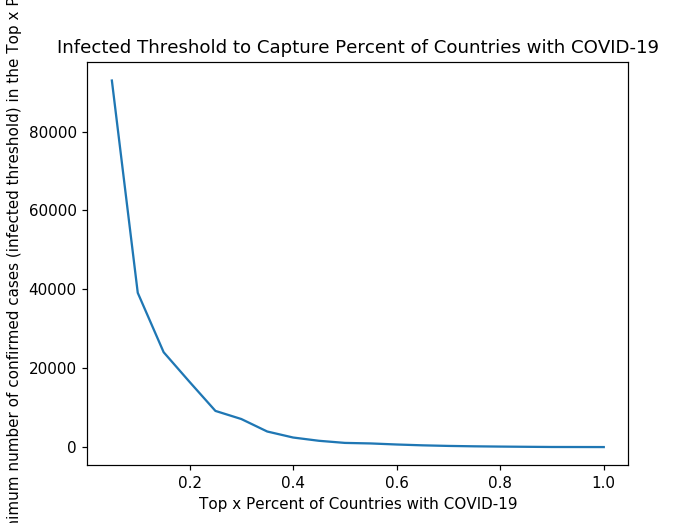

In [30]:
plt.plot([xx for xx in np.arange(0.05, 1.05, 0.05)], 
         [ get_initial_infect_thresh(data_confirmed, xx) for xx in np.arange(0.05, 1.05, 0.05)])
plt.title("Infected Threshold to Capture Percent of Countries with COVID-19")
plt.xlabel("Top x Percent of Countries with COVID-19")
plt.ylabel("The minimum number of confirmed cases (infected threshold) in the Top x Percent")
plt.show()

In [31]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 1.0)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs, location_pos, max_confirmed, infected_parents, new_locs, new_edges = get_infection_path(data_confirmed, 
                                                                                                       routes, 
                                                                                                       infect_thresh, 
                                                                                                       bin_region_column,
                                                                                                       border_closures=border_closures)

  0%|          | 0/125 [00:00<?, ?it/s]

INITIAL INFECTION THRESHOLD SET TO 1


100%|██████████| 125/125 [03:58<00:00,  1.91s/it]


In [32]:
dates = get_dates(data_confirmed, bin_region_column)

def get_avg_border_closure_date(border_closures, dates):
    sum_index = 0
    total_closures = 0
    
    for country in border_closures['country']:
        bc_list = border_closures['country'][country]
        dates_list = [bc_entry['date'] for bc_entry in bc_list]
        min_index = len(dates)-1
        for test_date in dates_list:
            test_index = dates.index(test_date)
            if test_index < min_index:
                min_index = test_index
                
        sum_index += min_index
        total_closures += 1
        
    for state in border_closures['state']:
        bc_list = border_closures['state'][state]
        dates_list = [bc_entry['date'] for bc_entry in bc_list]
        min_index = len(dates)-1
        for test_date in dates_list:
            test_index = dates.index(test_date)
            if test_index < min_index:
                min_index = test_index
                
        sum_index += min_index
        total_closures += 1
        
    return dates[int(sum_index/total_closures)]
        
avg_lockdown_date = get_avg_border_closure_date(border_closures, dates)
print("The average date when countries implemented severe travel restrictions: {}".format(avg_lockdown_date))

The average date when countries implemented severe travel restrictions: 3/23/20


In [33]:
conn_components = sorted(nx.connected_components(infect_graphs[dates[-1]]), key=len)
total_locations = 0
for component in conn_components:
    total_locations += len(component)

largest_component = len(conn_components[-1])
infection_graph_percent = largest_component/total_locations
print("Infection Graph Captures {}% of all Infected Locations".format(infection_graph_percent*100))
conn_components

Infection Graph Captures 90.53627760252367% of all Infected Locations


[{'none:San Marino'},
 {'none:Monaco'},
 {'none:Andorra'},
 {'none:Liechtenstein'},
 {'none:West Bank and Gaza'},
 {'none:Holy See'},
 {'Channel Islands:United Kingdom'},
 {'Grand Princess:Canada'},
 {'none:Eswatini'},
 {'none:Suriname'},
 {'none:Namibia'},
 {'Greenland:Denmark'},
 {'District of Columbia:US'},
 {'Montserrat:United Kingdom'},
 {'none:El Salvador'},
 {'Bermuda:United Kingdom'},
 {'Isle of Man:United Kingdom'},
 {'Northwest Territories:Canada'},
 {'Yukon:Canada'},
 {'none:Kosovo'},
 {'Anguilla:United Kingdom'},
 {'British Virgin Islands:United Kingdom'},
 {'Turks and Caicos Islands:United Kingdom'},
 {'Falkland Islands (Malvinas):United Kingdom'},
 {'Saint Pierre and Miquelon:France'},
 {'none:Western Sahara'},
 {'none:Yemen'},
 {'none:Comoros'},
 {'none:Tajikistan'},
 {'none:Lesotho'},
 {'Alabama:US',
  'Alaska:US',
  'Alberta:Canada',
  'Anhui:China',
  'Arizona:US',
  'Arkansas:US',
  'Aruba:Netherlands',
  'Australian Capital Territory:Australia',
  'Beijing:China',
 

<IPython.core.display.Javascript object>


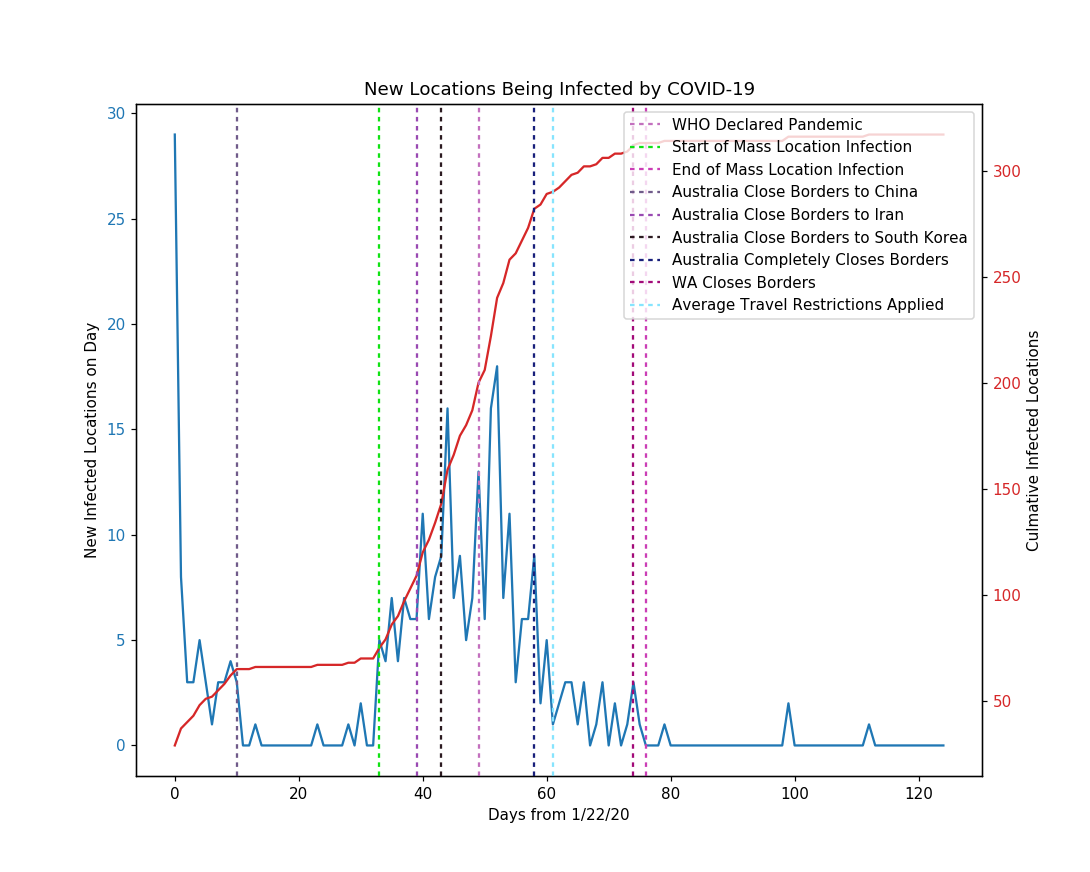

In [34]:
keypoints_timeline = {
    "WHO Declared Pandemic" : "3/11/20",
    "Start of Mass Location Infection" : "2/24/20",
    "End of Mass Location Infection" : "4/7/20",
    "Australia Close Borders to China" : "2/1/20",
    "Australia Close Borders to Iran" : "3/1/20",
    "Australia Close Borders to South Korea" : "3/5/20",
    "Australia Completely Closes Borders" : "3/20/20",
    "WA Closes Borders" : "4/5/20",
    "Average Travel Restrictions Applied": avg_lockdown_date
}

def plot_new_locations_infected(new_locs, dates, keypoints_timeline,
                                title="New Locations Being Infected by COVID-19"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(10,8))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('New Infected Locations on Day')
    ax0.plot(from_day_zero, new_infections, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
    
    ax2.legend(legend_list)
    plt.title(title)
    plt.show()
    fig.savefig("./figures/statecountry_new_infections.png", bbox_inches='tight')

plot_new_locations_infected(new_locs, dates, keypoints_timeline)

In [35]:
def get_routes_including_loc(node_loc, routes, from_node, bin_region_column):
    node_loc_split = node_loc.split(':')
    
    county_key = "{}County"
    state_key = "{}Province/State"
    country_key = "{}Country/Region"
    
    dir_str = "Arrival"
    if from_node:
        dir_str = "Depart"
    
    county_key = county_key.format(dir_str)
    state_key = state_key.format(dir_str)
    country_key = country_key.format(dir_str)
    
    if bin_region_column == 'county':
        return routes.loc[
            (routes[county_key] == node_loc_split[0]) &
            (routes[state_key] == node_loc_split[1]) &
            (routes[country_key] == node_loc_split[2])
        ]
    elif bin_region_column == 'state':
        return routes.loc[
            (routes[state_key] == node_loc_split[0]) &
            (routes[country_key] == node_loc_split[1])
        ]
    else:
        return routes.loc[
            (routes[country_key] == node_loc_split[0])
        ]

def get_num_routes_from_infect_cluster_to_clean_cluster(infect_graphs, routes, dates, bin_region_column):
    total_infect_to_clean = [0 for ii in range(len(dates))]
    
    def join_to_node_loc_format(row, from_node, bin_region_column):
        county_key = "{}County"
        state_key = "{}Province/State"
        country_key = "{}Country/Region"

        dir_str = "Depart"
        if from_node:
            dir_str = "Arrival"
            
        county_key = county_key.format(dir_str)
        state_key = state_key.format(dir_str)
        country_key = country_key.format(dir_str)
        
        if bin_region_column == 'county':
            return "{}:{}:{}".format(row[county_key], row[state_key], row[country_key])
        elif bin_region_column == 'state':
            return "{}:{}".format(row[state_key], row[country_key])
        else:
            return "{}".format(row[country_key])
        
    def is_connected_to_uninfected(infect_loc, routes, from_node, total_infect_to_clean, 
                                   infected_locations, bin_region_column):
        is_conn = False
        infect_routes = get_routes_including_loc(infect_loc, routes, from_node, bin_region_column)

        for _index, row in infect_routes.iterrows():
            other_node_loc = join_to_node_loc_format(row, from_node, bin_region_column)
            if not other_node_loc in infected_locations:
                is_conn = True
                total_infect_to_clean[date_index] = total_infect_to_clean[date_index] + 1
            
        return total_infect_to_clean, is_conn
    
    for date_index in tqdm(range(len(dates))):
        date = dates[date_index]
        
        infect_graph = infect_graphs[date]
        infected_locations = infect_graph.nodes
        
        for infect_loc in infected_locations:
            total_infect_to_clean, is_conn = is_connected_to_uninfected(infect_loc, routes, True, 
                                                                        total_infect_to_clean, infected_locations, 
                                                                        bin_region_column)
            if is_conn: continue
                
            total_infect_to_clean, is_conn = is_connected_to_uninfected(infect_loc, routes, False, 
                                                                        total_infect_to_clean, infected_locations, 
                                                                        bin_region_column)
    
    return total_infect_to_clean

In [36]:
total_infect_to_clean = get_num_routes_from_infect_cluster_to_clean_cluster(infect_graphs, 
                                                                            routes, 
                                                                            dates, 
                                                                            bin_region_column)

100%|██████████| 125/125 [03:10<00:00,  1.52s/it]


<IPython.core.display.Javascript object>


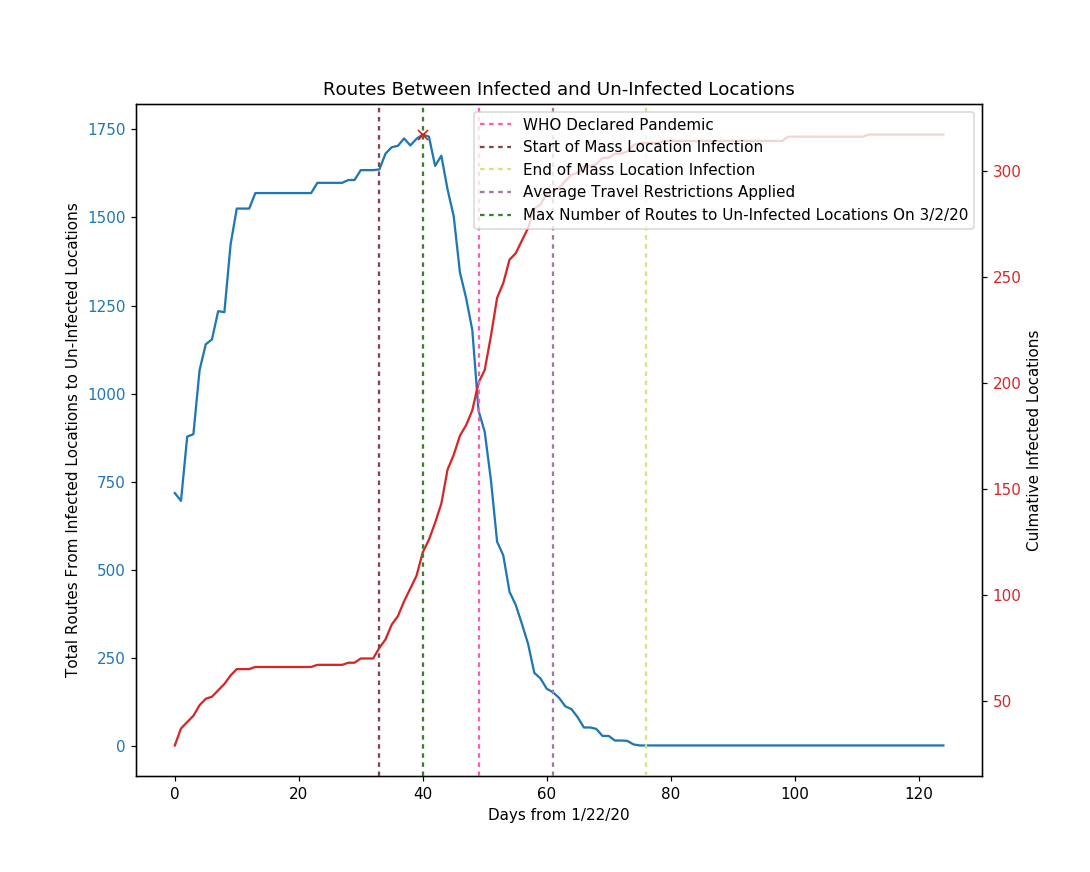

In [40]:
keypoints_timeline = {
    "WHO Declared Pandemic" : "3/11/20",
    "Start of Mass Location Infection" : "2/24/20",
    "End of Mass Location Infection" : "4/7/20",
    "Average Travel Restrictions Applied": avg_lockdown_date
}

def plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, keypoints_timeline,
                                         title="Routes Between Infected and Un-Infected Locations",
                                         save_loc="./figures/statecountry_infecttouninfect_paths.png"
                                        ):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(10,8))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('Total Routes From Infected Locations to Un-Infected Locations')
    ax0.plot(from_day_zero, total_infect_to_clean, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
        
    max_total_paths = max(total_infect_to_clean)
    max_total_paths_index = total_infect_to_clean.index(max_total_paths)
    
    crit_label = 'Max Number of Routes to Un-Infected Locations On {}'.format(dates[max_total_paths_index])
    ax0.plot(max_total_paths_index, max_total_paths, 'rx')
    ax2.axvline(max_total_paths_index, 0, max(new_infections_culm),
                label=crit_label, c=np.random.rand(3,), dashes=(2,2))
    legend_list.append(crit_label)
    
    ax2.legend(legend_list)
    plt.title(title)
    plt.show()
    fig.savefig(save_loc, bbox_inches='tight')
    
plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, keypoints_timeline)

Looks like that mass infection started on the 2/24/20 and the critical point was on the 3/2/20.

Lets look at the countries that were infected from 1/22/20 to 3/2/20.

In [41]:
def get_countries_infected_between_date(new_locs, dates, start_date, final_date):
    if final_date == 'latest':
        final_date = dates[-1]
        
    start_date_index = dates.index(start_date)
    final_date_index = dates.index(final_date)
    
    new_locs_range = {}
    for date_index in range(start_date_index, final_date_index+1):
        date = dates[date_index]
        new_locs_range[date] = new_locs[date]
    return new_locs_range
#     print("Infected Locations From {} To {}".format(start_date, final_date))
#     infect_locs_list = []
#     for date in new_locs_range:
#         infect_list = infect_locs_in_range_dict[date]
#         if len(infect_list) > 0:
#             print(date)
#             print("\t{}".format(infect_list))
#             infect_locs_list = infect_locs_list + infect_list
    
#     return infect_locs_list

start_date = '1/22/20'
final_date = '3/2/20'
infect_locs_in_range = get_countries_infected_between_date(new_locs, dates, start_date, final_date)
infect_locs_in_range

{'1/22/20': ['Hubei:China',
  'Anhui:China',
  'none:Taiwan*',
  'none:Korea, South',
  'Ningxia:China',
  'Hebei:China',
  'Jiangsu:China',
  'Fujian:China',
  'Shanxi:China',
  'Guizhou:China',
  'Macau:China',
  'Washington:US',
  'Yunnan:China',
  'Shandong:China',
  'Jiangxi:China',
  'none:Japan',
  'Guangxi:China',
  'Liaoning:China',
  'none:Thailand',
  'Hainan:China',
  'Hunan:China',
  'Tianjin:China',
  'Sichuan:China',
  'Henan:China',
  'Chongqing:China',
  'Shanghai:China',
  'Zhejiang:China',
  'Beijing:China',
  'Guangdong:China'],
 '1/23/20': ['none:Singapore',
  'Jilin:China',
  'none:Vietnam',
  'Xinjiang:China',
  'Hong Kong:China',
  'Heilongjiang:China',
  'Gansu:China',
  'Shaanxi:China'],
 '1/24/20': ['Inner Mongolia:China', 'Illinois:US', 'none:France'],
 '1/25/20': ['Qinghai:China', 'none:Nepal', 'none:Malaysia'],
 '1/26/20': ['Arizona:US',
  'Ontario:Canada',
  'Victoria:Australia',
  'California:US',
  'New South Wales:Australia'],
 '1/27/20': ['none:German

In [42]:
def scatter_confirmed_cases_infecting(latest_infect_graph, infected_parents, bin_region_column='state', 
                                      case_zero_name='Hubei:China',
                                      title="Number of Possible Infections a Location could of Caused and Confirmed Cases by the 5/23/20"):
    confirmed_cases = nx.get_node_attributes(latest_infect_graph, 'confirmed')
    
    if bin_region_column == 'country':
        new_confirmed_cases = {}
        
        for loc in confirmed_cases:
            num_of_cases = confirmed_cases[loc]
            country = loc.split(":")[-1]
            new_confirmed_cases[country] = new_confirmed_cases.get(country, 0) + num_of_cases
        
        confirmed_cases = new_confirmed_cases
        
        new_infected_parents = {}
        
        for loc in infected_parents:
            country = loc.split(':')[-1]
            possible_infects = infected_parents[loc]
            new_possible_infects = []
            for p_infect in possible_infects:
                p_country = p_infect.split(':')[-1]
                if p_country in new_possible_infects: continue
                new_possible_infects.append(p_country)
            new_infected_parents[country] = new_infected_parents.get(country, []) + new_possible_infects
        
        infected_parents = new_infected_parents
        case_zero_name = case_zero_name.split(':')[-1]
    
    small_possible_infections = []
    small_confirmed_cases_of_loc = []
    
    worst_countries = {}
    worst_possible_infections = []
    worst_confirmed_cases_of_loc = []
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    for infecting_parent in infected_parents:
        num_of_cases = confirmed_cases[infecting_parent]
        if num_of_cases >= 170000:
            worst_countries[infecting_parent] = {
                'possibly_infected' : len(infected_parents[infecting_parent]),
                'confirmed' : int(num_of_cases)
            }
            if infecting_parent == case_zero_name: continue
            worst_possible_infections.append(len(infected_parents[infecting_parent]))
            worst_confirmed_cases_of_loc.append(num_of_cases)
        else:
            if infecting_parent == case_zero_name: continue
            small_possible_infections.append(len(infected_parents[infecting_parent]))
            small_confirmed_cases_of_loc.append(num_of_cases)
        
    ax.scatter(small_possible_infections, small_confirmed_cases_of_loc, c='g')
    ax.scatter(worst_possible_infections, worst_confirmed_cases_of_loc, c='r')
    ax.scatter(len(infected_parents[case_zero_name]), confirmed_cases[case_zero_name], c='y')
    ax.axhline(170000, 0, max(small_possible_infections), c='b', dashes=(2,2))
    ax.set_xlabel("Number of Possible Infections a Location could of Caused")
    ax.set_ylabel("Number of Confirmed Cases at Location")
    ax.legend([
        "Severe Threshold: 170 000 cases",
        "Locations Not Severely Impacting",
        "Locations Severely Impacting",
        "Case Zero: {}".format(case_zero_name)
    ])
    plt.title(title)
    fig.savefig("./figures/{}_possiblyinfected_confirmedcases.png".format(bin_region_column), bbox_inches='tight')
    plt.show()
    return worst_countries
    

<IPython.core.display.Javascript object>


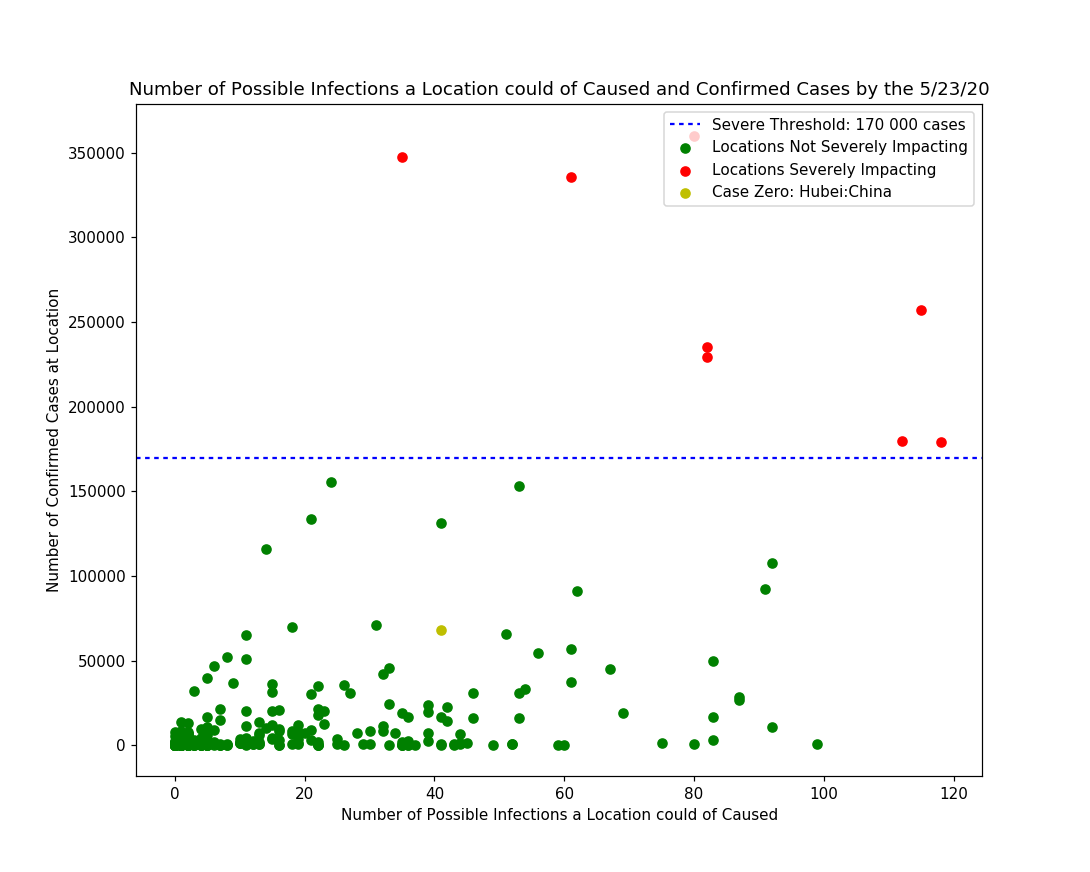

In [45]:
latest_date = '5/23/20'
latest_infect_graph = infect_graphs[latest_date]
worst_locations_state_lvl = scatter_confirmed_cases_infecting(latest_infect_graph, infected_parents[latest_date])

In [16]:
worst_locations_state_lvl

{'none:France': {'possibly_infected': 118, 'confirmed': 179306},
 'none:Germany': {'possibly_infected': 112, 'confirmed': 179986},
 'none:United Kingdom': {'possibly_infected': 115, 'confirmed': 257154},
 'none:Italy': {'possibly_infected': 82, 'confirmed': 229327},
 'none:Russia': {'possibly_infected': 61, 'confirmed': 335882},
 'none:Spain': {'possibly_infected': 82, 'confirmed': 235290},
 'none:Brazil': {'possibly_infected': 35, 'confirmed': 347398},
 'New York:US': {'possibly_infected': 80, 'confirmed': 359926}}

<IPython.core.display.Javascript object>


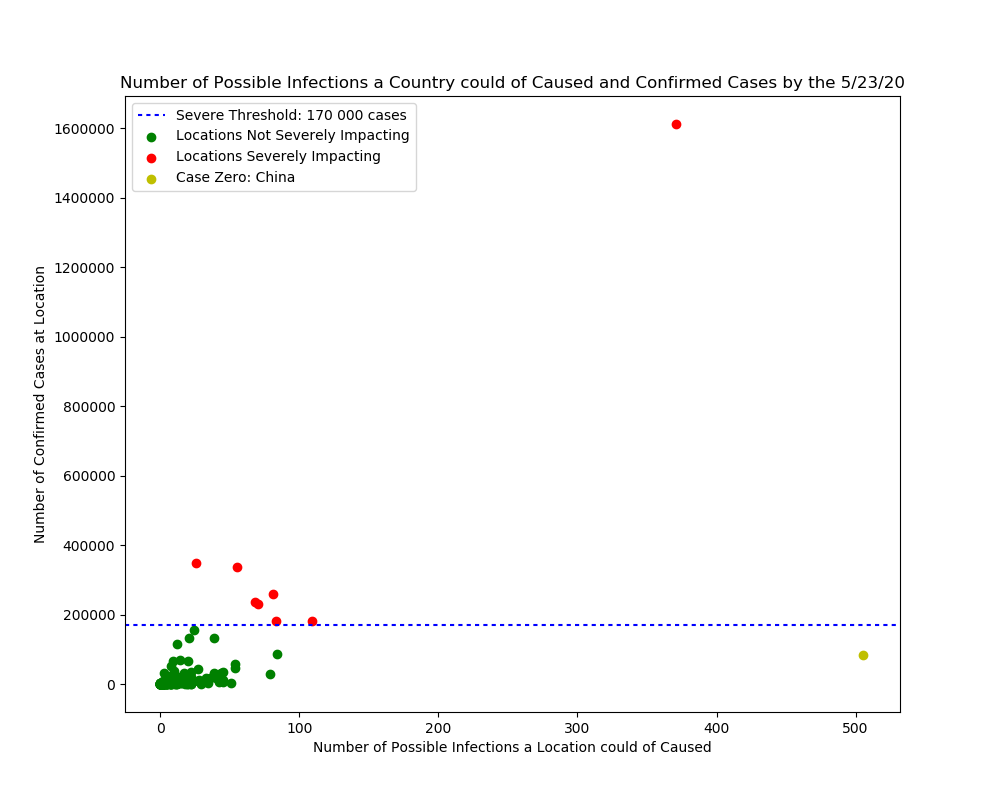

In [17]:
worst_locations_country_lvl = scatter_confirmed_cases_infecting(latest_infect_graph, infected_parents[latest_date],
                                                                bin_region_column='country',
                                                                title="Number of Possible Infections a Country could of Caused and Confirmed Cases by the 5/23/20")

In [18]:
worst_locations_country_lvl

{'US': {'possibly_infected': 371, 'confirmed': 1610779},
 'France': {'possibly_infected': 109, 'confirmed': 182036},
 'Germany': {'possibly_infected': 83, 'confirmed': 179986},
 'United Kingdom': {'possibly_infected': 81, 'confirmed': 258504},
 'Italy': {'possibly_infected': 70, 'confirmed': 229327},
 'Russia': {'possibly_infected': 55, 'confirmed': 335882},
 'Spain': {'possibly_infected': 68, 'confirmed': 235290},
 'Brazil': {'possibly_infected': 26, 'confirmed': 347398}}

In [27]:
def time_confirmed_cases_infecting(infect_graphs, infected_parents, severe_list, dates, bin_region_column='state',
                                   period = 1.0, annotate_all=False, start_final_dates=(None, None),
                                   title_format="COVID-19 Cases and Possible Infection Paths For Each Location on {}"):
    def scatter_confirmed_cases_infecting_time(fig, ax, infect_graph, infected_parents, severe_list, annotate_all, 
                                               bin_region_column='state',
                                               case_zero_name='Hubei:China',
                                               title=""):
        confirmed_cases = nx.get_node_attributes(infect_graph, 'confirmed')

        if bin_region_column == 'country':
            new_confirmed_cases = {}

            for loc in confirmed_cases:
                num_of_cases = confirmed_cases[loc]
                country = loc.split(":")[-1]
                new_confirmed_cases[country] = new_confirmed_cases.get(country, 0) + num_of_cases

            confirmed_cases = new_confirmed_cases

            new_infected_parents = {}

            for loc in infected_parents:
                country = loc.split(':')[-1]
                possible_infects = infected_parents[loc]
                new_possible_infects = []
                for p_infect in possible_infects:
                    p_country = p_infect.split(':')[-1]
                    if p_country in new_possible_infects: continue
                    new_possible_infects.append(p_country)
                new_infected_parents[country] = new_infected_parents.get(country, []) + new_possible_infects

            infected_parents = new_infected_parents
            case_zero_name = case_zero_name.split(':')[-1]

        small_possible_infections = []
        small_confirmed_cases_of_loc = []

        worst_possible_infections = []
        worst_confirmed_cases_of_loc = []

        annotate_list = []

        for infecting_parent in infected_parents:
            num_of_cases = confirmed_cases[infecting_parent]
            if infecting_parent in severe_list: 
                possible_infections = len(infected_parents[infecting_parent])
                worst_possible_infections.append(possible_infections)
                worst_confirmed_cases_of_loc.append(num_of_cases)
                annotate_list.append((infecting_parent, possible_infections, num_of_cases))
                continue
                
            if infecting_parent == case_zero_name: continue
                
            possible_infections = len(infected_parents[infecting_parent])
            small_possible_infections.append(possible_infections)
            small_confirmed_cases_of_loc.append(num_of_cases)
            
            if annotate_all:
                annotate_list.append((infecting_parent, possible_infections, num_of_cases))
        
        if annotate_all:
            annotate_list.append((case_zero_name, len(infected_parents[case_zero_name]), confirmed_cases[case_zero_name]))
        
        ax.clear()
        ax.scatter(small_possible_infections, small_confirmed_cases_of_loc, c='g')
        ax.scatter(worst_possible_infections, worst_confirmed_cases_of_loc, c='r')
        ax.scatter(len(infected_parents[case_zero_name]), confirmed_cases[case_zero_name], c='y')
        ax.set_xlabel("Number of Possible Infections a Location could of Caused")
        ax.set_ylabel("Number of Confirmed Cases at Location")
        ax.legend([
            "Locations Not Severely Impacting",
            "Locations Severely Impacting",
            "Case Zero: {}".format(case_zero_name)
        ])
        
        for loc, p_infects, cases in annotate_list:
            loc_split = loc.split(':')
            label = loc_split[-1]
            if not loc_split[0] == 'none':
                label = "{}, {}".format(loc_split[0], loc_split[1])
            ax.annotate(label,
                        (p_infects, cases),
                        textcoords = 'offset points',
                        xytext = (0,5),
                        ha='center',
                        size=6
                       )
        ax.set_title(title)
        fig.canvas.draw()
        
    fig, ax = plt.subplots(figsize=(10,8))
    
    if not start_final_dates[0] == None:
        start_date_index = dates.index(start_final_dates[0])
        final_date_index = dates.index(start_final_dates[1])

        new_dates = []
        for date_index in range(start_date_index, final_date_index+1):
            date = dates[date_index]
            new_dates.append(date)
        dates = new_dates
    
    for date in dates:
        scatter_confirmed_cases_infecting_time(fig, ax, infect_graphs[date], infected_parents[date], severe_list, 
                                               annotate_all, title=title_format.format(date))
        time.sleep(period)

<IPython.core.display.Javascript object>


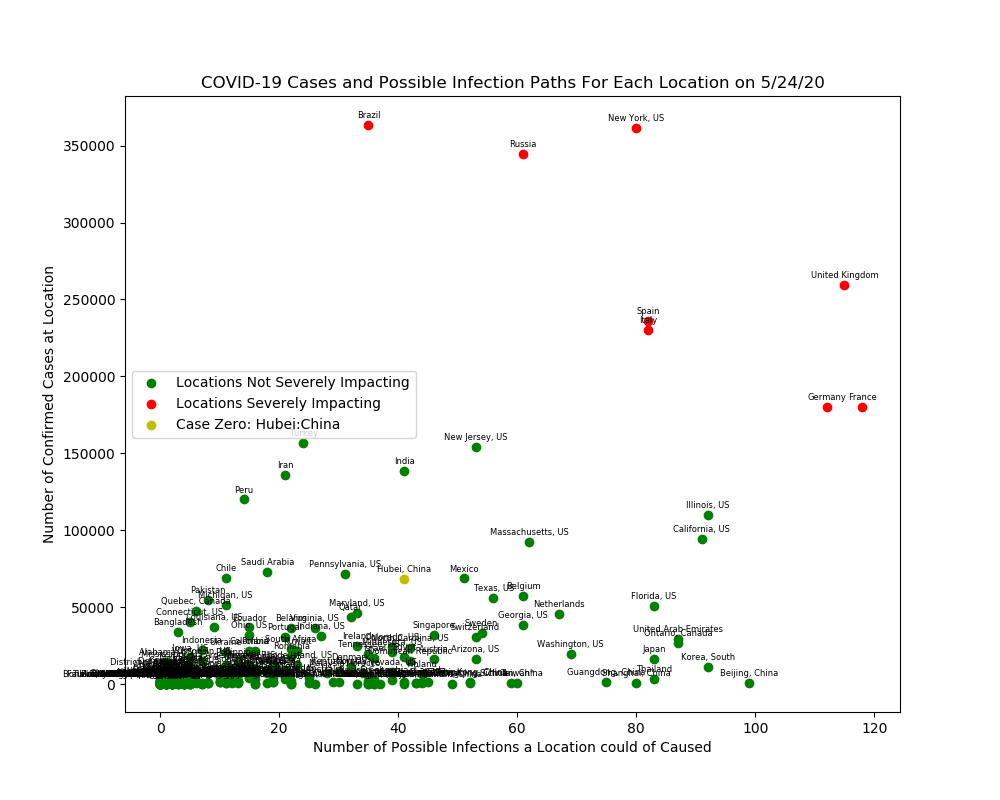

In [29]:
time_confirmed_cases_infecting(infect_graphs, infected_parents, worst_locations_state_lvl, dates, 
                               period=0.0, annotate_all=True)

<IPython.core.display.Javascript object>


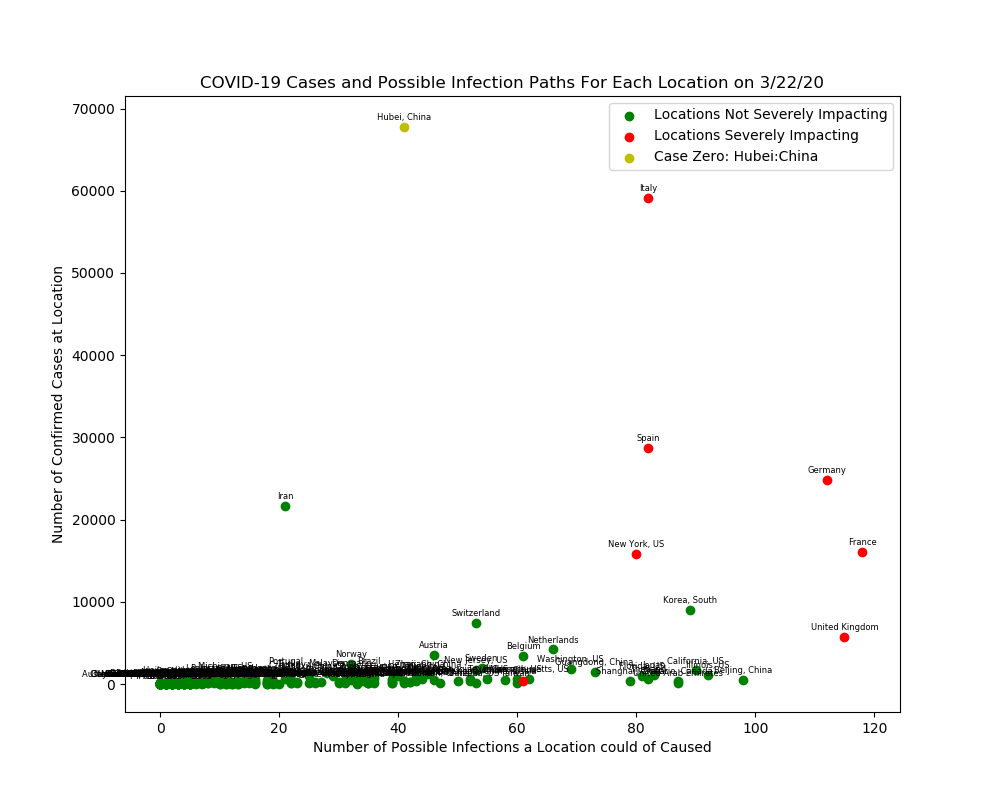

In [28]:
time_confirmed_cases_infecting(infect_graphs, infected_parents, worst_locations_state_lvl, dates, 
                               period=0.1, annotate_all=True, start_final_dates=('1/22/20', '3/22/20'))

In [43]:
KEY_CONTRIBUTORS = [
    "none:Italy",
    "none:France",
    "none:United Kingdom",
    "none:Spain",
    "none:Germany",
    "New York:US",
    "none:Korea, South",
    "Hubei:China",
    "none:Iran"
]

<IPython.core.display.Javascript object>


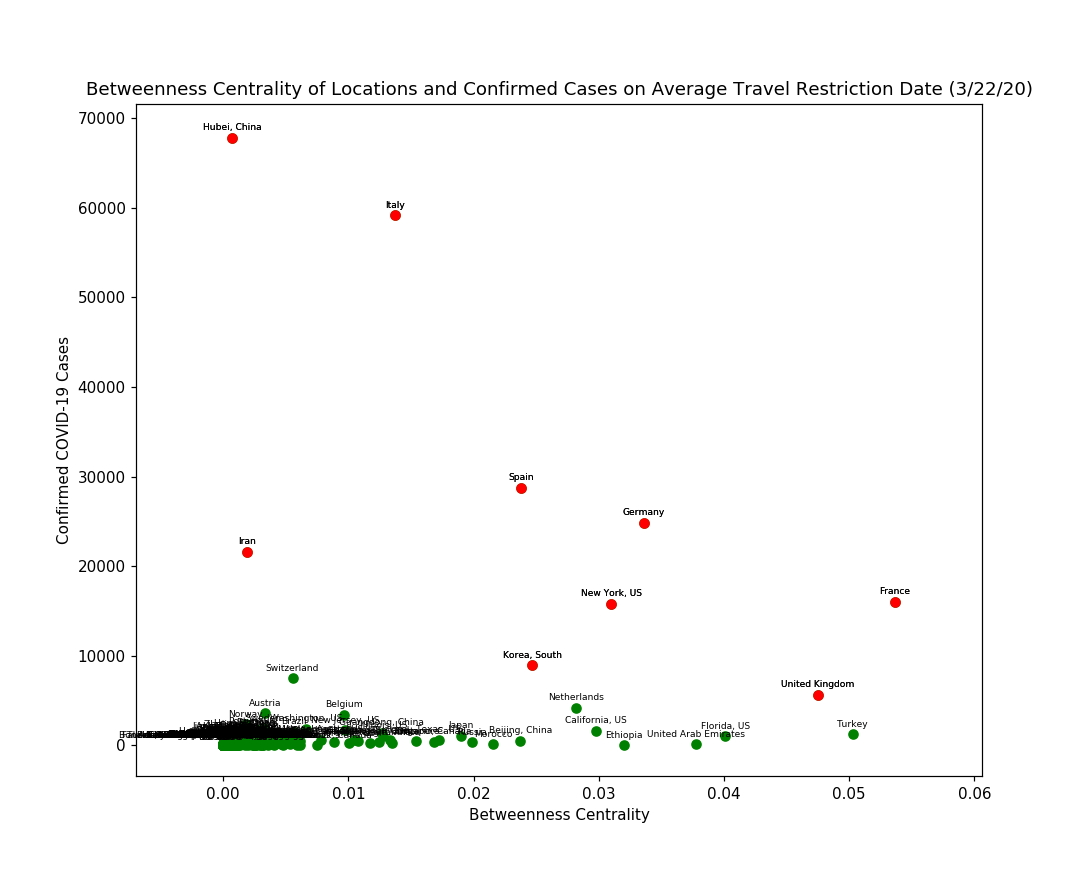

In [46]:
def plot_betweenness_centrality(infect_graphs, data_confirmed, date, contributors, 
                                bin_region_column=bin_region_column,
                                title = "Betweenness Centrality of Locations and Confirmed Cases on Average Travel Restriction Date (3/22/20)"
                               ):
    betweenness_centrality_dict = nx.betweenness_centrality(infect_graphs[latest_date])
    
    plot_list = []
    contrib_list = []
    for loc in betweenness_centrality_dict:
        num_of_cases = get_cases_on_date(loc, data_confirmed, date, bin_region_column).tolist()[0]
        if loc in contributors:
            contrib_list.append((loc, betweenness_centrality_dict[loc], num_of_cases))
        plot_list.append((loc, betweenness_centrality_dict[loc], num_of_cases))
        
    fig, ax = plt.subplots(figsize=(10,8))
    plot_list_x = [entry[1] for entry in plot_list]
    plot_list_y = [entry[2] for entry in plot_list]
    
    contrib_list_x = [entry[1] for entry in contrib_list]
    contrib_list_y = [entry[2] for entry in contrib_list]
    ax.scatter(plot_list_x, plot_list_y, c='g')
    ax.scatter(contrib_list_x, contrib_list_y, c='r')
    ax.set_xlabel("Betweenness Centrality")
    ax.set_ylabel("Confirmed COVID-19 Cases")
    
    for loc, between, cases in plot_list + contrib_list:
        loc_split = loc.split(':')
        label = loc_split[-1]
        if not loc_split[0] == 'none':
            label = "{}, {}".format(loc_split[0], loc_split[1])
        ax.annotate(label,
                (between, cases),
                textcoords = 'offset points',
                xytext = (0,5),
                ha='center',
                size=6)
    ax.set_title(title)
    fig.savefig("./figures/{}_betweennesscentrality_confirmedcases.png".format(bin_region_column), bbox_inches='tight')
    
plot_betweenness_centrality(infect_graphs, data_confirmed, '3/22/20', KEY_CONTRIBUTORS)

In [9]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 1.0)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs_k, location_pos_k, max_confirmed_k, infected_parents_k, new_locs_k, new_edges_k = get_infection_path(data_confirmed, 
                                                                                                       routes, 
                                                                                                       infect_thresh, 
                                                                                                       bin_region_column,
                                                                                                       border_closures=border_closures,
                                                                                                       key_locations=KEY_CONTRIBUTORS)

  0%|          | 0/125 [00:00<?, ?it/s]

INITIAL INFECTION THRESHOLD SET TO 1


100%|██████████| 125/125 [04:15<00:00,  2.05s/it]


In [47]:
conn_components_k = sorted(nx.connected_components(infect_graphs_k[dates[-1]]), key=len)
largest_conn_component_orig = len(conn_components[-1])
largest_conn_component_key_contribs = len(conn_components_k[-1])
no_direct_conn_to_contrib = list(conn_components[-1] - conn_components_k[-1])
percent_decrease = largest_conn_component_key_contribs/largest_conn_component_orig
print("Largest Connected Component from Original Infection Graph:\n\t{}".format(largest_conn_component_orig))
print("Largest Connected Component from Just Key Contributors Infection Graph:\n\t{}".format(
    largest_conn_component_key_contribs))
print("Key Contributors Captures {}% of The Original Highly Connected Component of the Infection Graph Connections".format(percent_decrease*100))
print("Key Contributors Captures {}% of all infected locations".format(largest_conn_component_key_contribs/total_locations))
print("Locations that did not have a direct route and open border with a Key Contributor")
no_direct_conn_to_contrib

Largest Connected Component from Original Infection Graph:
	287
Largest Connected Component from Just Key Contributors Infection Graph:
	232
Key Contributors Captures 80.8362369337979% of The Original Highly Connected Component of the Infection Graph Connections
Key Contributors Captures 0.7318611987381703% of all infected locations
Locations that did not have a direct route and open border with a Key Contributor


['none:Dominica',
 'none:Eritrea',
 'none:Kyrgyzstan',
 'none:Gambia',
 'none:Nicaragua',
 'none:Sao Tome and Principe',
 'none:Madagascar',
 'none:Cabo Verde',
 'Qinghai:China',
 'none:Sierra Leone',
 'Saint Barthelemy:France',
 'none:Guinea-Bissau',
 'none:South Sudan',
 'none:Timor-Leste',
 'Kansas:US',
 'none:Bhutan',
 'none:Botswana',
 'Montana:US',
 'French Polynesia:France',
 'none:Papua New Guinea',
 'none:Angola',
 'none:Central African Republic',
 'none:Niger',
 'Jiangxi:China',
 'St Martin:France',
 'Tibet:China',
 'none:Mozambique',
 'Prince Edward Island:Canada',
 'South Australia:Australia',
 'none:Zimbabwe',
 'none:Uganda',
 'none:Sudan',
 'Bonaire, Sint Eustatius and Saba:Netherlands',
 'South Dakota:US',
 'none:Zambia',
 'none:Liberia',
 'none:Somalia',
 'Inner Mongolia:China',
 'none:Libya',
 'none:Malawi',
 'none:Chad',
 'Northern Territory:Australia',
 'none:Belize',
 'Tasmania:Australia',
 'Saskatchewan:Canada',
 'Western Australia:Australia',
 'none:Saint Kitts an

In [48]:
latest_date = dates[-1]
sum_infect_not_conn = 0
for loc in no_direct_conn_to_contrib:
    loc_split = loc.split(':')
    sum_infect_not_conn += data_confirmed.loc[(data_confirmed['Province/State'] ==  loc_split[0]) &
                                             (data_confirmed['Country/Region'] == loc_split[1])
                                            ][latest_date].tolist()[0]

avg_infect_not_conn = int(sum_infect_not_conn/len(no_direct_conn_to_contrib))
print("Average Number of COVID-19 Cases Among Locations with No Connection to Key Contributors On {}:\n\t{}".format(latest_date, avg_infect_not_conn))

Average Number of COVID-19 Cases Among Locations with No Connection to Key Contributors On 5/25/20:
	684


In [49]:
def get_infection_rate(data_confirmed, dates, location_list, bin_region_column, ignore_thresh=1):
    infection_rates = {}
    start_date = dates[0]
    for loc in location_list:
        infect_rate_list = []
        prev_num_of_cases = 0
        for date in dates:
            if date == start_date:
                prev_num_of_cases = get_cases_on_date(loc, data_confirmed, date, bin_region_column).tolist()[0]
                infect_rate_list.append(0)
                continue
            num_of_cases = get_cases_on_date(loc, data_confirmed, date, bin_region_column).tolist()[0]
            if num_of_cases >= ignore_thresh:
                if not prev_num_of_cases == 0:
                    infect_rate_list.append(num_of_cases/prev_num_of_cases)
                else:
                    infect_rate_list.append(1)
            else:
                infect_rate_list.append(0)
            prev_num_of_cases = num_of_cases
            
        infection_rates[loc] = {dates[index] : infect_rate_list[index] for index in range(len(infect_rate_list))}
    return infection_rates
    
key_contributors_r_coefficient = get_infection_rate(data_confirmed, dates, KEY_CONTRIBUTORS, bin_region_column)

In [50]:
key_contributors_r_coefficient['none:Germany']

{'1/22/20': 0,
 '1/23/20': 0,
 '1/24/20': 0,
 '1/25/20': 0,
 '1/26/20': 0,
 '1/27/20': 1,
 '1/28/20': 4.0,
 '1/29/20': 1.0,
 '1/30/20': 1.0,
 '1/31/20': 1.25,
 '2/1/20': 1.6,
 '2/2/20': 1.25,
 '2/3/20': 1.2,
 '2/4/20': 1.0,
 '2/5/20': 1.0,
 '2/6/20': 1.0,
 '2/7/20': 1.0833333333333333,
 '2/8/20': 1.0,
 '2/9/20': 1.0769230769230769,
 '2/10/20': 1.0,
 '2/11/20': 1.1428571428571428,
 '2/12/20': 1.0,
 '2/13/20': 1.0,
 '2/14/20': 1.0,
 '2/15/20': 1.0,
 '2/16/20': 1.0,
 '2/17/20': 1.0,
 '2/18/20': 1.0,
 '2/19/20': 1.0,
 '2/20/20': 1.0,
 '2/21/20': 1.0,
 '2/22/20': 1.0,
 '2/23/20': 1.0,
 '2/24/20': 1.0,
 '2/25/20': 1.0625,
 '2/26/20': 1.588235294117647,
 '2/27/20': 1.7037037037037037,
 '2/28/20': 1.0434782608695652,
 '2/29/20': 1.6458333333333333,
 '3/1/20': 1.6455696202531647,
 '3/2/20': 1.2230769230769232,
 '3/3/20': 1.2327044025157232,
 '3/4/20': 1.336734693877551,
 '3/5/20': 1.8396946564885497,
 '3/6/20': 1.3900414937759336,
 '3/7/20': 1.1925373134328359,
 '3/8/20': 1.3016270337922402,
 '

In [51]:
def get_when_community_spread_start(r_coefficients, dates, consecutive_days=5, r_threshold=3, r_step=0.01, r_ceil=2.0):
    community_spread = {}
    for loc in r_coefficients:
        rates = list(r_coefficients[loc].values())
        for ii in range(len(rates) - consecutive_days):
            r_avg = sum([rates[index] if rates[index] < r_ceil else r_ceil for index in range(ii, ii+consecutive_days)])/consecutive_days
            if r_avg > r_threshold and rates[ii] > r_threshold:
                community_spread[loc] = dates[ii]
                break
                
    if community_spread.keys() == r_coefficients.keys():
        return community_spread, r_threshold
    return get_when_community_spread_start(r_coefficients, dates, 
                                           consecutive_days=consecutive_days, r_threshold=r_threshold-r_step, 
                                           r_step=r_step)
                
conn_sec_days = 5
comm_spread_start, r_thresh = get_when_community_spread_start(key_contributors_r_coefficient, dates, 
                                                              consecutive_days = conn_sec_days)
print("Average Severe Infection Ratio From {} Consecutive Days: {}".format(conn_sec_days, r_thresh))
comm_spread_start

Average Severe Infection Ratio From 5 Consecutive Days: 1.3900000000000208


{'none:Italy': '2/21/20',
 'none:France': '2/27/20',
 'none:United Kingdom': '3/1/20',
 'none:Spain': '2/25/20',
 'none:Germany': '2/26/20',
 'New York:US': '3/3/20',
 'none:Korea, South': '2/20/20',
 'Hubei:China': '1/26/20',
 'none:Iran': '2/20/20'}

In [52]:
# The dates were afterwards R > 1.3 and remained up there for 4 following days (done by sight)
KEY_CONTRIBUTORS_COMMUNITY_SPREAD = {}
comm_spread_format = "{} starts community spreading"
for loc in comm_spread_start:
    loc_split = loc.split(':')
    readable_name = loc_split[-1]
    if not loc_split[0] == 'none':
        readable_name = "{}, {}".format(loc_split[0], loc_split[1])
        
    KEY_CONTRIBUTORS_COMMUNITY_SPREAD[comm_spread_format.format(readable_name)] = comm_spread_start[loc]

key_contribs_markers = KEY_CONTRIBUTORS_COMMUNITY_SPREAD.copy()
key_contribs_markers["WHO Declared Pandemic"] = "3/11/20"
key_contribs_markers["Average Date Travel Restrictions Applied"] = avg_lockdown_date
KEY_CONTRIBUTORS_COMMUNITY_SPREAD

{'Italy starts community spreading': '2/21/20',
 'France starts community spreading': '2/27/20',
 'United Kingdom starts community spreading': '3/1/20',
 'Spain starts community spreading': '2/25/20',
 'Germany starts community spreading': '2/26/20',
 'New York, US starts community spreading': '3/3/20',
 'Korea, South starts community spreading': '2/20/20',
 'Hubei, China starts community spreading': '1/26/20',
 'Iran starts community spreading': '2/20/20'}

<IPython.core.display.Javascript object>


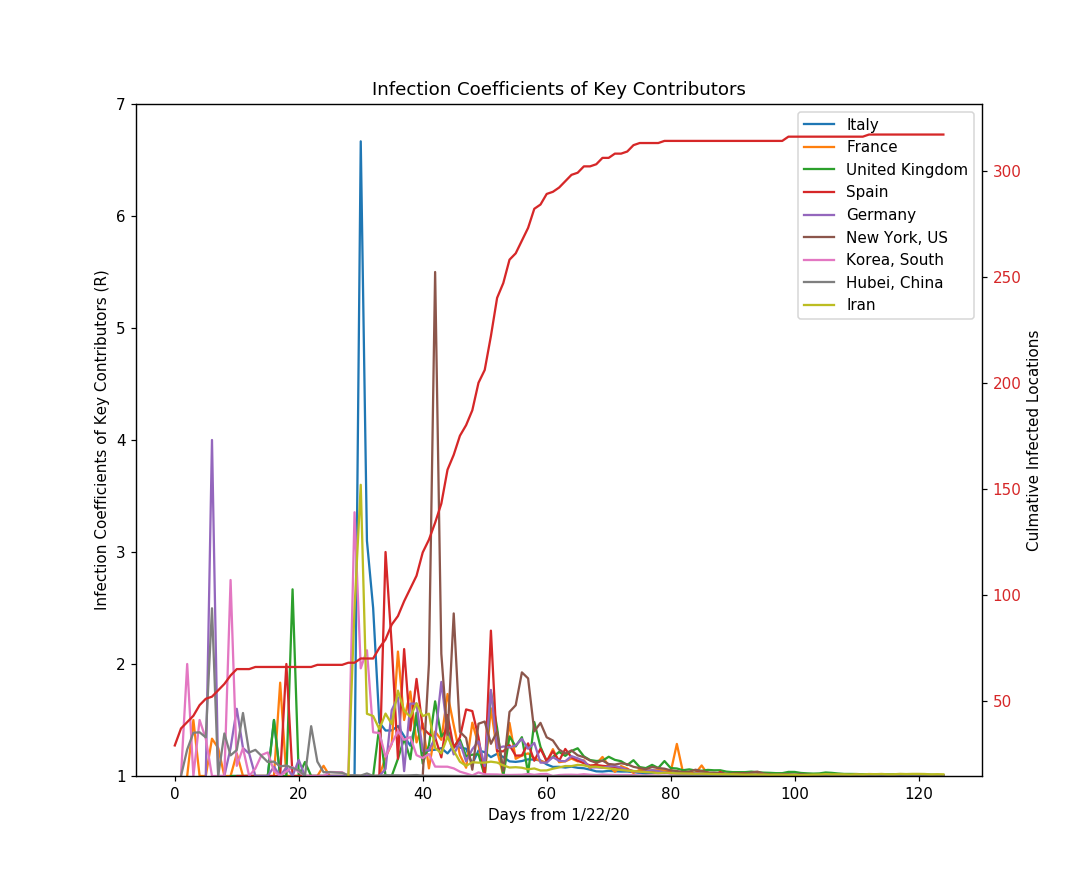

In [53]:
def plot_rcoefficients(new_locs, r_coefficients, dates,
                                         title="Infection Coefficients of Key Contributors"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(10,8))
    
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('Infection Coefficients of Key Contributors (R)')
    legend_list = []
    for loc in r_coefficients:
        r_values = list(r_coefficients[loc].values())
        ax0.plot(from_day_zero, r_values)
        loc_split = loc.split(':')
        label = loc_split[-1]
        if not loc_split[0] == 'none':
            label = "{}, {}".format(loc_split[0], loc_split[1])
            
        legend_list.append(label)
            
    ax0.set_ylim(bottom=1.0)
    ax0.legend(legend_list)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    plt.title(title)
    plt.show()
    fig.savefig("./figures/state_keycontibutors_r_coefficient.png", bbox_inches='tight')
    
plot_rcoefficients(new_locs, key_contributors_r_coefficient, dates, 
                                     title="Infection Coefficients of Key Contributors")

<IPython.core.display.Javascript object>


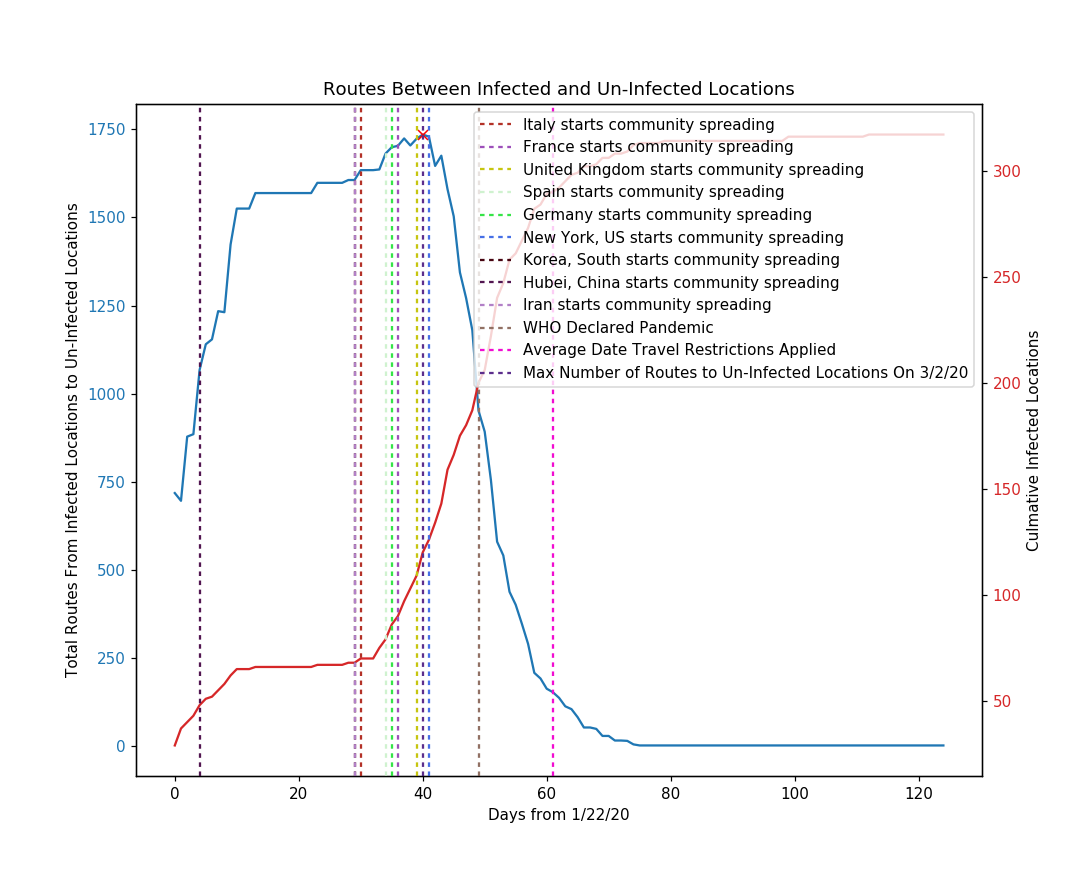

In [54]:
plot_total_paths_from_infect_cluster(new_locs, total_infect_to_clean, dates, key_contribs_markers,
                                     save_loc='./figures/state_routesbetweeninfectanduninfect_showingcomspreads.png')

<IPython.core.display.Javascript object>


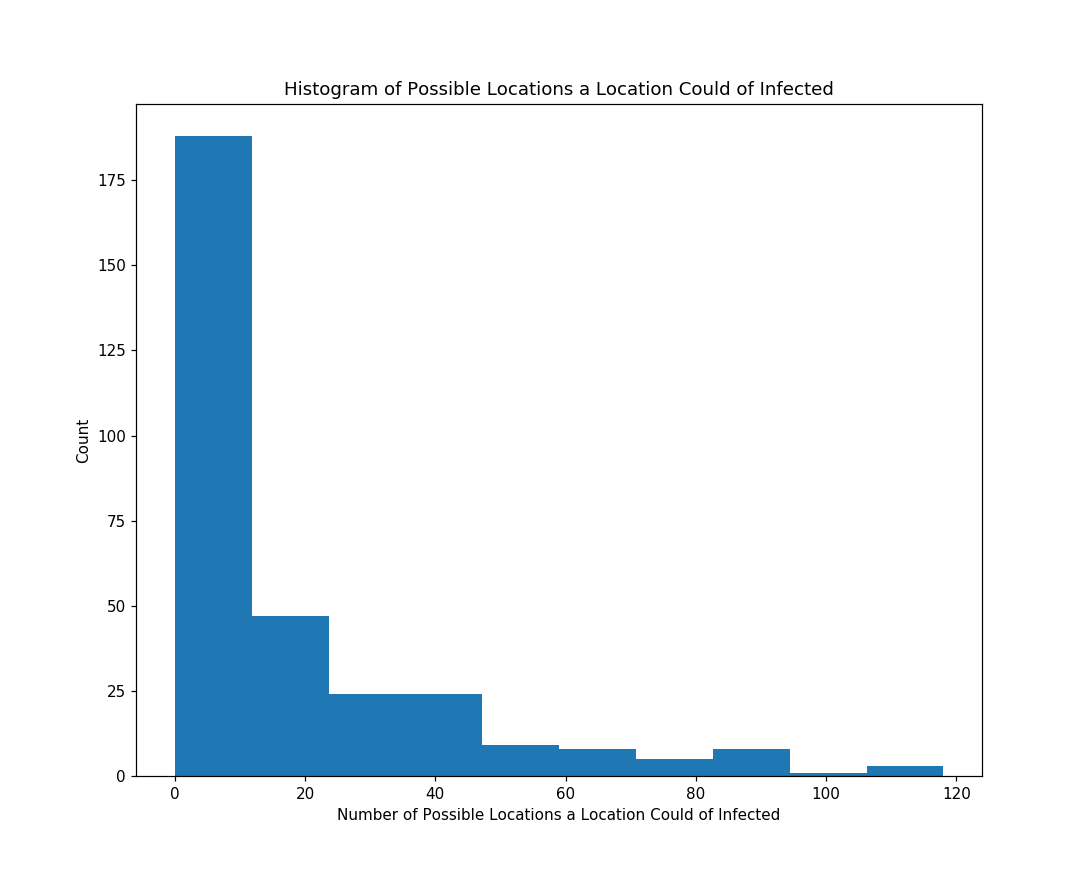

In [153]:
def plot_possible_infect_distribution(infected_parents, latest_date):
    ip_date = infected_parents[latest_date]
    total_possible_infects = [len(ip_date[parent]) for parent in ip_date]
    total_possible_infects = sorted(total_possible_infects, reverse=True)
    
    step = 1/len(total_possible_infects)
    plot_x = [x for x in np.arange(0, 1.0, step)]
    fig, ax = plt.subplots(figsize=(10,8))
    ax.hist(total_possible_infects)
    ax.set_title("Histogram of Possible Locations a Location Could of Infected")
    ax.set_ylabel("Count")
    ax.set_xlabel("Number of Possible Locations a Location Could of Infected")
    fig.savefig("./figures/state_possibleinfects_powerlaw.png", bbox_inches='tight')
    
plot_possible_infect_distribution(infected_parents, latest_date)

In [65]:
def get_full_routes_network(routes):
    routes_graph = nx.Graph()
    for _index, row in routes.iterrows():
        from_place = "{}:{}".format(row['DepartProvince/State'], row['DepartCountry/Region'])
        to_place = "{}:{}".format(row['ArrivalProvince/State'], row['ArrivalCountry/Region'])
        routes_graph.add_edge(from_place, to_place)
        
    return routes_graph

routes_graph = get_full_routes_network(routes)
routes_bc = nx.betweenness_centrality(routes_graph)
routes_dd = dict(routes_graph.degree)

In [68]:
infection_rates = get_infection_rate(data_confirmed, dates, list(infect_graphs[dates[-1]].nodes), 
                                              bin_region_column, ignore_thresh=1)

In [75]:
def get_bcdd_metric(routes_bc, routes_dd, infect_rates, dates, previous_days=5, r_ceil=2):
    bcdd_values = np.zeros((len(dates)))
    for dates_index in range(previous_days, len(dates)):
        for loc in infect_rates:
            rates = list(infect_rates[loc].values())
            r_avg = sum([rates[index] if rates[index] < r_ceil else r_ceil 
                         for index in range(dates_index-previous_days, dates_index)])/previous_days
            
            try:
                bcdd_v = r_avg * routes_bc[loc]*routes_dd[loc]
            except:
                continue
            
            bcdd_values[dates_index] = bcdd_values[dates_index] + bcdd_v
            
    return bcdd_values

bcdd_values = get_bcdd_metric(routes_bc, routes_dd, infection_rates, dates)
bcdd_values

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  27.23900741,  36.01615459,  43.05699606,
        46.27125717,  48.706265  ,  54.89646997,  60.75350293,
        63.64911561,  67.39896762,  71.00893911,  69.96229151,
        68.79561929,  69.54617293,  70.95918677,  71.45847839,
        73.2327826 ,  73.4164317 ,  72.21158096,  70.08395476,
        69.34215729,  67.59321883,  67.52654886,  67.40359671,
        67.35772483,  67.35737992,  67.43407516,  68.16325321,
        69.36936438,  69.96169682,  71.33145954,  72.5009492 ,
        74.25913977,  78.48507034,  82.41228451,  88.02849245,
        93.52727731,  99.86184599, 105.47371667, 112.35911572,
       118.7949087 , 124.84339293, 129.96417589, 131.0870647 ,
       129.92331839, 129.33475327, 130.28142954, 127.16252478,
       133.73695684, 137.51109835, 136.86977434, 138.69172998,
       142.91301795, 140.16921637, 141.43933934, 144.00246073,
       142.31934543, 140.47850806, 137.52600135, 134.81

<IPython.core.display.Javascript object>


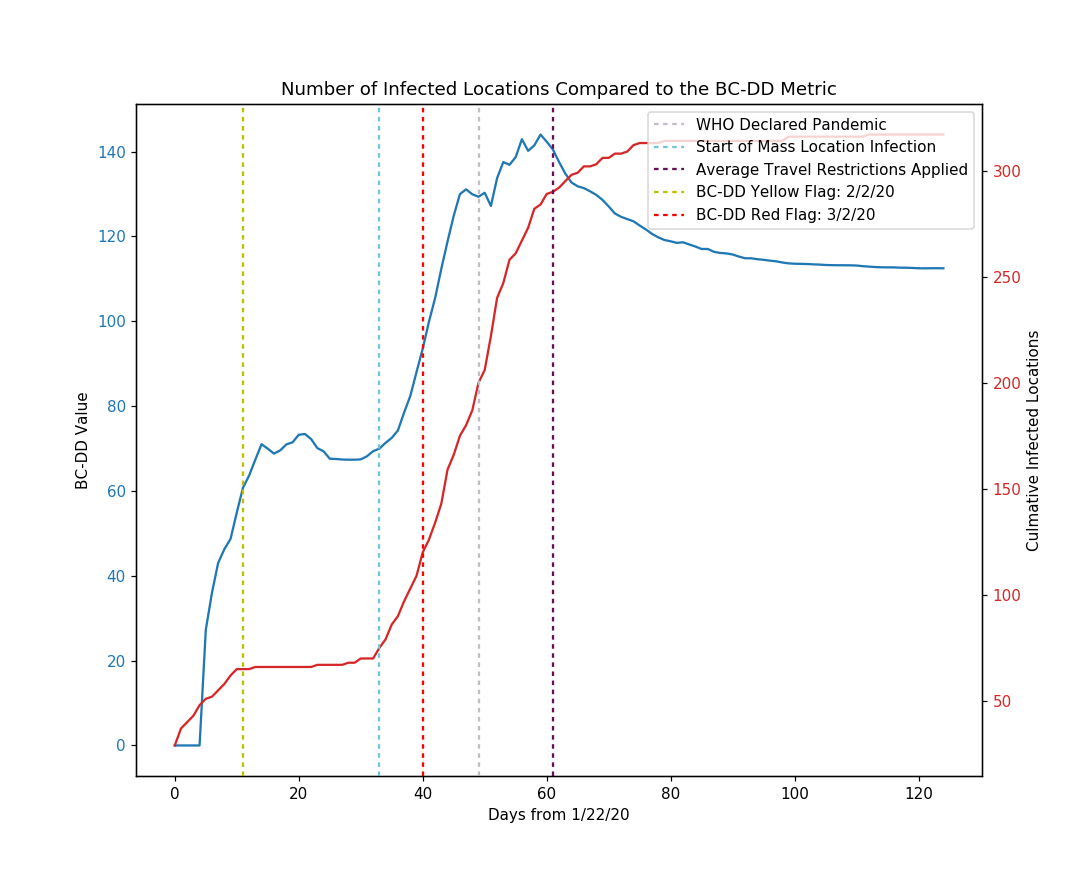

In [85]:
keypoints_timeline = {
    "WHO Declared Pandemic" : "3/11/20",
    "Start of Mass Location Infection" : "2/24/20",
    "Average Travel Restrictions Applied": avg_lockdown_date
}

def plot_bcdd(new_locs, bcdd_values, dates, keypoints_timeline,
              title="Number of Infected Locations Compared to the BC-DD Metric"):
    from_day_zero = [day_index for day_index in range(len(dates))]
    new_infections = [len(new_locs[date]) for date in dates]
    new_infections_culm = [new_infections[0]]
    
    for index in range(1, len(new_infections)):
        new_infections_culm.append(new_infections[index] + new_infections_culm[index-1])
    
    fig, ax0 = plt.subplots(figsize=(10,8))
    
    color = 'tab:blue'
    ax0.set_xlabel('Days from 1/22/20')
    ax0.set_ylabel('BC-DD Value')
    ax0.plot(from_day_zero, bcdd_values, color=color)
    ax0.tick_params(axis='y', labelcolor=color)
    
    ax1 = ax0.twinx()
    
    color = 'tab:red'
    ax1.set_xlabel('Days from 1/22/20')
    ax1.set_ylabel('Culmative Infected Locations')
    ax1.plot(from_day_zero, new_infections_culm, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax0.twinx()
    ax2.get_yaxis().set_visible(False)
    legend_list = []
    for key_event in keypoints_timeline:
        key_event_index = dates.index(keypoints_timeline[key_event])
        ax2.axvline(key_event_index, 0, max(new_infections_culm), 
                    label=key_event, c=np.random.rand(3,), dashes=(2,2))
        legend_list.append(key_event)
        
    for ii in range(1, len(bcdd_values)):
        if bcdd_values[ii-1] < 60 and bcdd_values[ii] >= 60:
            label = "BC-DD Yellow Flag: {}".format(dates[ii])
            legend_list.append(label)
            ax2.axvline(ii, 0, max(new_infections_culm), 
                    label=label, c='y', dashes=(2,2))
        
        if bcdd_values[ii-1] < 90 and bcdd_values[ii] >= 90:
            label = "BC-DD Red Flag: {}".format(dates[ii])
            legend_list.append(label)
            ax2.axvline(ii, 0, max(new_infections_culm), 
                    label=label, c='r', dashes=(2,2))
            break
    ax2.legend(legend_list)
    plt.title(title)
    plt.show()
    fig.savefig("./figures/state_bcdd.png", bbox_inches='tight')
    
plot_bcdd(new_locs, bcdd_values, dates, keypoints_timeline)

In [22]:
class TimeMapAnimation:

    def __init__(self, infect_graphs, location_pos, data_confirmed, routes, new_locs, new_edges, bin_region_column, 
                 date_list=None, zoom=1.0, scale=3, dynamic_line_opacity=False, line_opacity=0.02, center = (0,0), 
                 date_msg_format = '<p style="color:red">Date: <b>{date}</b></p>', verbose=False, period=1.0, 
                 wait_time=5.0):
        
        self.infect_graphs = infect_graphs
        self.location_pos = location_pos
        self.data_confirmed = data_confirmed
        self.routes = routes  
        self.new_locs = new_locs
        self.new_edges = new_edges
        self.bin_region_column = bin_region_column
        
        self.dates = get_dates(self.data_confirmed, self.bin_region_column) if date_list == None else date_list
        self.date_msg_format = date_msg_format
        self.date_msg = HTML()
        self._updateDateMsg(self.dates[0])
        
        self.verbose = verbose
        self.period = period
        self.line_opacity = line_opacity
        self.scale = scale
        self.wait_time = wait_time
        self.dynamic_line_opacity = dynamic_line_opacity
        
        if self.dynamic_line_opacity:
            self.line_opacity_fn = lambda routes_between, max_routes: routes_between/max_routes
        else:
            self.line_opacity_fn = lambda routes_between, max_routes: self.line_opacity
        
        self.marker_layer = None
        self.circle_layer = None
        self.line_layer = None
        
        self.time_infection_map = Map(basemap=basemaps.CartoDB.DarkMatter, 
                                      center=(0,0), 
                                      zoom=zoom,
                                      scroll_wheel_zoom=True,
                                     )
        self.time_infection_map.add_control(FullScreenControl())
        self.time_infection_map.add_control(WidgetControl(widget=self.date_msg, position='topright'))
        
    def displayMap(self):
        """
        This function needs to be called on last line of a Jupyter Notebook cell to display the Map
        """
        return self.time_infection_map
    
    def startAnimation(self):
        self._clearLayers()
        
        self._print("Starting Animation in {} seconds".format(self.wait_time))
        time.sleep(self.wait_time)
        
        for date in self.dates:
            self._print("Current Date: {}".format(date))
            if date == self.dates[0]:
                self._initializeMap()
                continue
            else:
                self._updateLayers(date)
                
            time.sleep(self.period)
                
    def _updateDateMsg(self, date):
        self.date_msg.value = self.date_msg_format.format(date=date)
                
    def _print(self, msg):
        if self.verbose:
            print(msg)
    
    def _clearLayers(self):
        if self.marker_layer == None:
            return
        else:
            self.infection_map.remove_layer(self.marker_layer)
            self.infection_map.remove_layer(self.circle_layer)
            self.infection_map.remove_layer(self.line_layer)
            
        
    def _updateLayers(self, date):
        if self.dynamic_line_opacity:
            max_route = max(self.routes['NumberOfRoutes'])
        else:
            max_route = None
        
        self._updateDateMsg(date)
        
        # Adding new locations to the layers on the Map
        for name_loc in self.new_locs[date]:
            self._print("New Infected Location: {}".format(name_loc))
            
            marker = Marker(location=self.location_pos[name_loc], draggable=False, title=name_loc, opacity=0)
            self.marker_layer.add_layer(marker)

            circle = Circle(location=self.location_pos[name_loc], 
                            radius=int(get_cases_on_date(name_loc, 
                                                         self.data_confirmed, 
                                                         date, 
                                                         self.bin_region_column)*self.scale),#/max_confirm*scale),
                            color = 'red', fill_color = 'red')
            self.circle_layer.add_layer(circle)

        # Adding new edges to the layers on the Map
        for c1, c2 in self.new_edges[date]:
            self._print("New Edge Between {} and {}".format(c1, c2))
            
            c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, 
                                                                               self.routes, 
                                                                               self.bin_region_column)
            try:
                c1_to_c2 = self.routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c1_to_c2 = 0
            try:
                c2_to_c1 = self.routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c2_to_c1 = 0
            
            routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
            
            line = Polyline(locations=[self.location_pos[c1], self.location_pos[c2]], 
                            color='white', opacity=self.line_opacity_fn(routes_between, max_route))
            
            self.line_layer.add_layer(line)

        # Updating prexisting locations on the Map
        for circle in self.circle_layer.layers:
            lat, long = circle.location
            circle.radius = self._getInfectedAtLocation(lat, long, date)
        
    def _getInfectedAtLocation(self, lat, long, date):
        name_loc = None
        for test_name_loc in self.location_pos:
            test_lat, test_long = self.location_pos[test_name_loc]
            if test_lat == lat and test_long == long:
                name_loc = test_name_loc
                break

        assert not name_loc == None, "Ok... something has really messed up here..."

        return int(get_cases_on_date(name_loc, self.data_confirmed, date, self.bin_region_column)*self.scale)
        
    
    def _initializeMap(self):
        date = self.dates[0]
        self._updateDateMsg(date)
        infect_graph = self.infect_graphs[date]
        # max_confirm = self.max_confirmed[date]
        
        self.marker_layer = LayerGroup(name='markers')
        self.circle_layer = LayerGroup(name='circles')
        self.line_layer = LayerGroup(name='lines')
        
        self.time_infection_map.add_layer(self.marker_layer)
        self.time_infection_map.add_layer(self.circle_layer)
        self.time_infection_map.add_layer(self.line_layer)
        
        for name_loc in infect_graph.nodes:
            marker = Marker(location=self.location_pos[name_loc], draggable=False, title=name_loc, visibile=True, opacity=0)
            self.marker_layer.add_layer(marker)

            circle = Circle(location=self.location_pos[name_loc], 
                            radius=int(get_cases_on_date(name_loc, 
                                                         self.data_confirmed, 
                                                         date, 
                                                         self.bin_region_column)*self.scale),#/self.max_confirm*scale),
                            color = 'red', fill_color = 'red')
            self.circle_layer.add_layer(circle)
            
        max_route = max(self.routes['NumberOfRoutes'])

        for c1, c2 in infect_graph.edges:
            c1_to_c2_bool_map, c2_to_c1_bool_map = route_indexes_between_nodes(c1, c2, self.routes, 
                                                                               self.bin_region_column)
            try:
                c1_to_c2 = self.routes.loc[c1_to_c2_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c1_to_c2 = 0
            try:
                c2_to_c1 = self.routes.loc[c2_to_c1_bool_map]['NumberOfRoutes'].tolist()[0]
            except:
                c2_to_c1 = 0
            
            routes_between = c1_to_c2 if c1_to_c2 > c2_to_c1 else c2_to_c1
            line = Polyline(locations = [self.location_pos[c1], self.location_pos[c2]], color='white', 
                            opacity = self.line_opacity_fn(routes_between, max_route))
            self.line_layer.add_layer(line)
        

In [28]:
animation_percent = TimeMapAnimation(infect_graphs, 
                                            location_pos, 
                                            data_confirmed, 
                                            routes, 
                                            new_locs, 
                                            new_edges,
                                            bin_region_column,
                                            wait_time=5.0,
                                            period=0.5,
                                           )
animation_percent.displayMap()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [ ]:
animation_percent.startAnimation()

In [23]:
animation_key_contribs = TimeMapAnimation(infect_graphs_k, 
                                          location_pos_k, 
                                          data_confirmed, 
                                          routes, 
                                          new_locs_k, 
                                          new_edges_k,
                                          bin_region_column,
                                          line_opacity=0.05,
                                          period=0.1)
animation_key_contribs.displayMap()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [24]:
animation_key_contribs.startAnimation()

In [16]:
infect_thresh = get_initial_infect_thresh(data_confirmed, 0.20)
if infect_thresh <= 0: infect_thresh = 1
print("INITIAL INFECTION THRESHOLD SET TO {}".format(infect_thresh))
infect_graphs_top_20, location_pos_top_20, max_confirmed_top_20, infected_parents_top_20, new_locs_top_20, new_edges_top_20 = get_infection_path(data_confirmed, 
                                                                                                                                                 routes, 
                                                                                                                                                 infect_thresh, 
                                                                                                                                                 bin_region_column,
                                                                                                                                                 border_closures=border_closures)

animation_top_20_percent = TimeMapAnimation(infect_graphs_top_20, 
                                            location_pos_top_20, 
                                            data_confirmed, 
                                            routes, 
                                            new_locs_top_20, 
                                            new_edges_top_20,
                                            bin_region_column,
                                            period=0.1,
                                           )
animation_top_20_percent.displayMap()

 46%|████▌     | 56/123 [00:00<00:00, 529.23it/s]

INITIAL INFECTION THRESHOLD SET TO 16053.0


100%|██████████| 123/123 [00:09<00:00, 13.04it/s]


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [17]:
animation_top_20_percent.startAnimation()

In [8]:
len(infect_graphs['5/23/20'].edges)

5358

In [111]:
len(infect_graphs['5/23/20'].edges)

5175

[{'none:San Marino'},
 {'none:Monaco'},
 {'none:Andorra'},
 {'none:Liechtenstein'},
 {'none:West Bank and Gaza'},
 {'none:Holy See'},
 {'Channel Islands:United Kingdom'},
 {'Grand Princess:Canada'},
 {'none:Eswatini'},
 {'none:Suriname'},
 {'none:Namibia'},
 {'Greenland:Denmark'},
 {'District of Columbia:US'},
 {'Montserrat:United Kingdom'},
 {'none:El Salvador'},
 {'Bermuda:United Kingdom'},
 {'Isle of Man:United Kingdom'},
 {'Northwest Territories:Canada'},
 {'Yukon:Canada'},
 {'none:Kosovo'},
 {'Anguilla:United Kingdom'},
 {'British Virgin Islands:United Kingdom'},
 {'Turks and Caicos Islands:United Kingdom'},
 {'Falkland Islands (Malvinas):United Kingdom'},
 {'Saint Pierre and Miquelon:France'},
 {'none:Western Sahara'},
 {'none:Yemen'},
 {'none:Comoros'},
 {'none:Tajikistan'},
 {'none:Lesotho'},
 {'Alabama:US',
  'Alaska:US',
  'Alberta:Canada',
  'Anhui:China',
  'Arizona:US',
  'Arkansas:US',
  'Aruba:Netherlands',
  'Australian Capital Territory:Australia',
  'Beijing:China',
 